In [8]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import random
import pickle
import pyarrow.parquet as pq
import warnings
import os
from utils.eval_funcs import *
from utils.tools import *

warnings.filterwarnings('ignore')

# 数据路径
data_path = '/data/local_data/shared/102/intern_data_yzhou'

In [2]:
# 获取预测数据
df_pred_xgb = pd.read_pickle(f'{data_path}/xgb_baseline_fea248_10min.pkl')
df_pred_xgb

,date,TimeStamp,ticker,model_pred
0,20200601,93500000,600000,0.483
1,20200601,94000000,600000,0.475
2,20200601,94500000,600000,0.465
3,20200601,95000000,600000,0.465
4,20200601,95500000,600000,0.456
...,...,...,...,...
28720984,20210331,142500000,300999,0.532
28720985,20210331,143000000,300999,0.525
28720986,20210331,143500000,300999,0.517
28720987,20210331,144000000,300999,0.526


In [3]:
# 获取评价用收益
# 起始日期
date_s = '20200601'
# 结束日期
date_e = '20210331'
parquet_path = f'{data_path}/zy4_parquet'

df_eval = get_eval_df(date_s, date_e, **{'data_path':parquet_path})
df_eval

,date,TimeStamp,ticker,m1_ts_y_mktval,m1_ts_y_60twap_2n1open_Wgted_fullmarket_ex,m1_ts_y_60twap_2n2open_Wgted_fullmarket_ex,m1_ts_y_60twap_2n3open_Wgted_fullmarket_ex
0,20200601,93500000,600000,297056784412.000,-0.014,-0.008,-0.016
1,20200601,94000000,600000,297056784412.000,-0.013,-0.007,-0.015
2,20200601,94500000,600000,297056784412.000,-0.011,-0.006,-0.014
3,20200601,95000000,600000,297056784412.000,-0.010,-0.005,-0.013
4,20200601,95500000,600000,297056784412.000,-0.010,-0.004,-0.012
...,...,...,...,...,...,...,...
28720984,20210331,142500000,300999,30178987574.000,0.000,0.041,0.029
28720985,20210331,143000000,300999,30178987574.000,0.001,0.041,0.029
28720986,20210331,143500000,300999,30178987574.000,0.001,0.042,0.029
28720987,20210331,144000000,300999,30178987574.000,0.001,0.042,0.029


In [5]:
param_dict = {
    'crss_ratio_thr': 0.03,
    'max_trade_time': 1,
    'index_code':'000905',
    'start_date':'20200601',
    'end_date':'20210331',
    'y_name':'m1_ts_y_60twap_2n1open_Wgted_fullmarket_ex',
    'data_path':data_path,
}


In [7]:
result_df = []

res_df_all = pd.merge(df_eval, df_pred_xgb, how='left')
result_df.append(get_eval_result(param_dict, res_df_all))
pd.DataFrame(result_df)

,rtn,sharpe,rtn_mtt,sharpe_mtt,turnover,rtn_fee,exp_size_mean,exp_size_min,exp_size_max,exp_bp_mean,exp_bp_min,exp_bp_max,exp_rv_mean,exp_rv_min,exp_rv_max,kcb_ratio_mean,kcb_ratio_max,cyb_ratio_mean,cyb_ratio_max
0,0.510,10.625,0.462,10.712,0.687,0.252,-0.950,-1.574,-0.232,-0.323,-0.781,0.337,0.037,-0.829,0.626,0.102,0.307,0.258,0.493


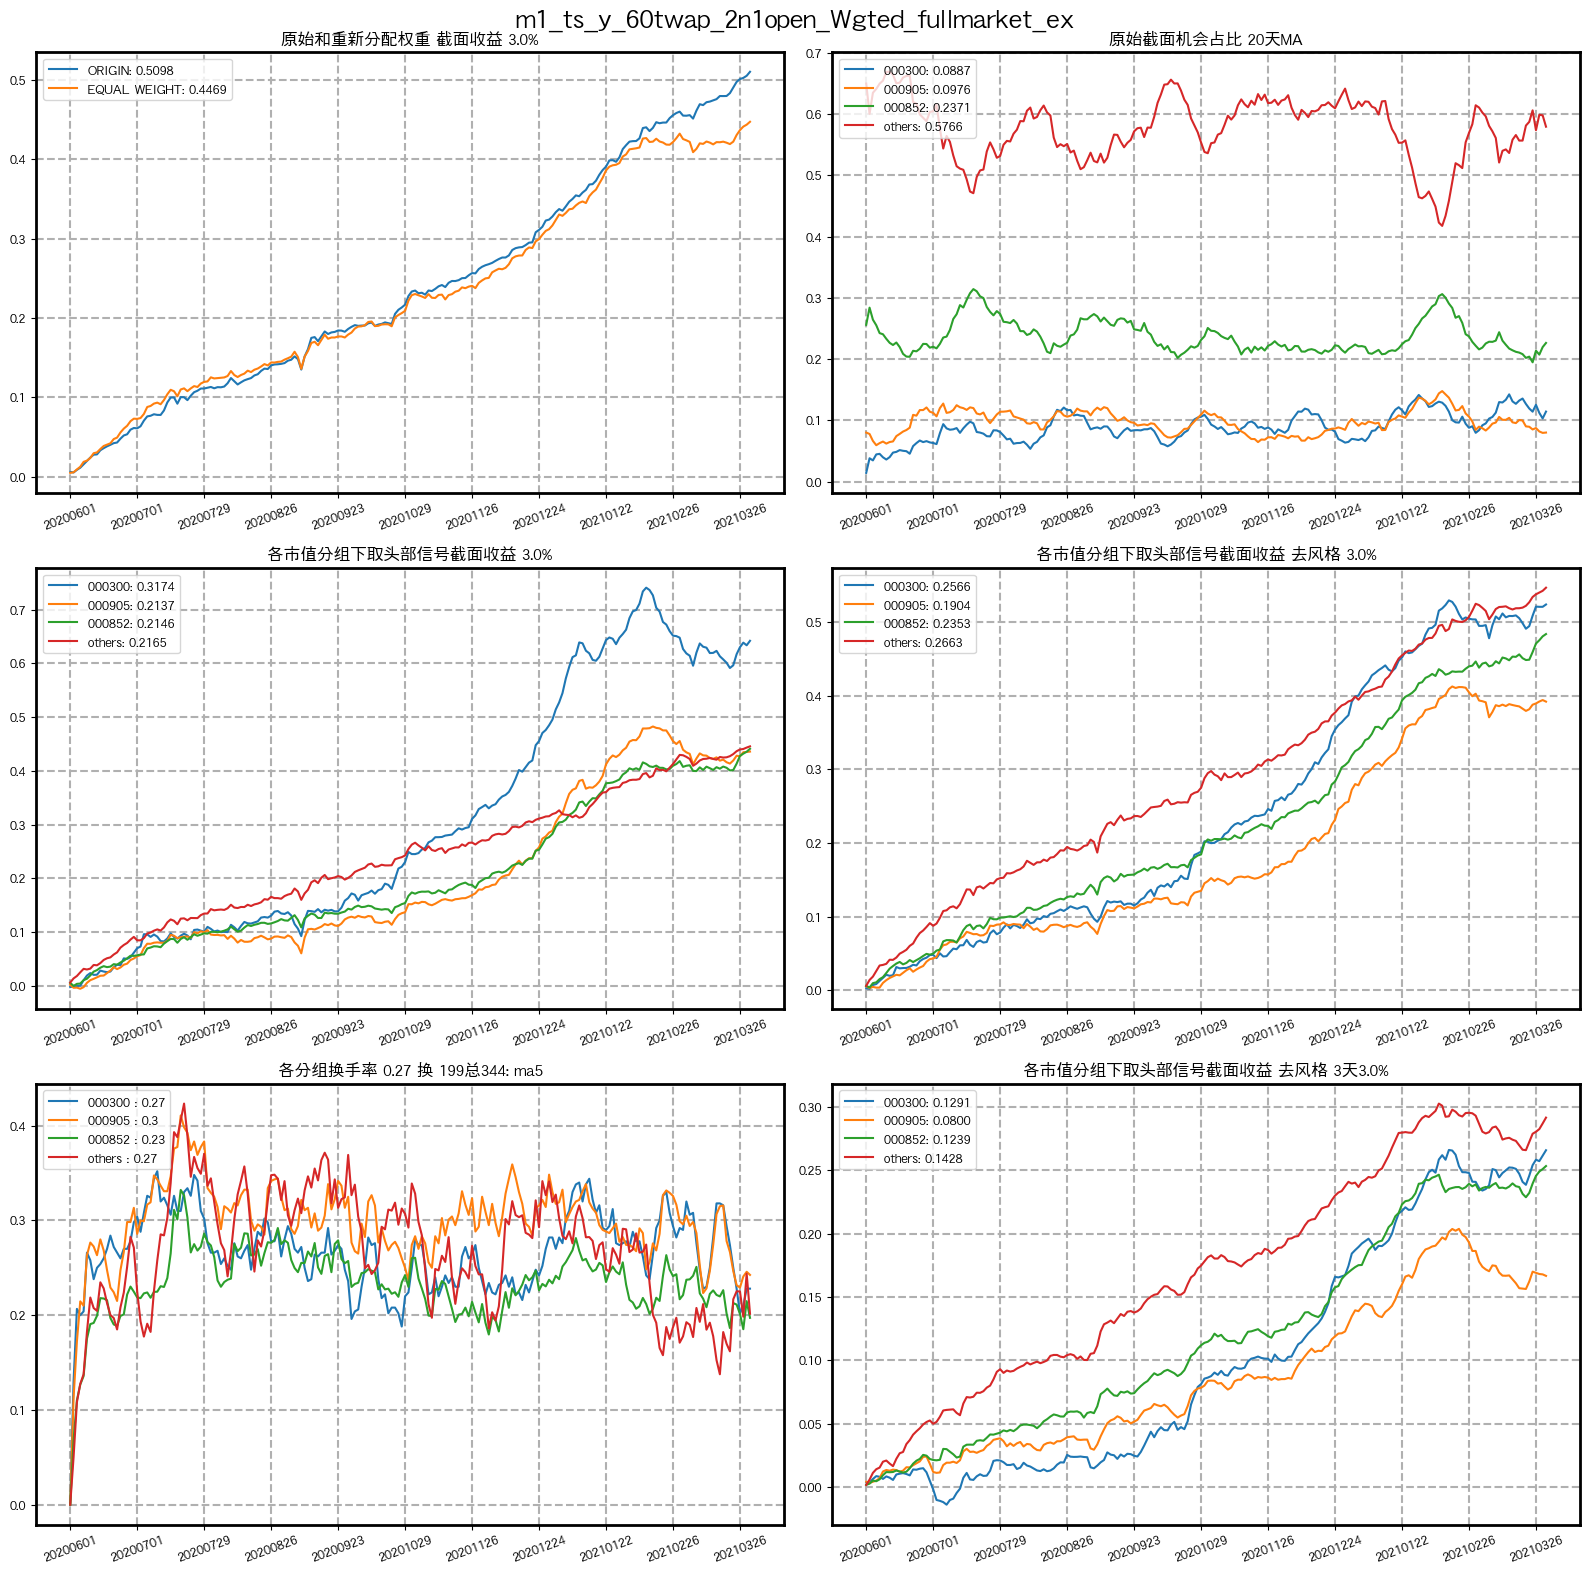

{'rtn_origin': 0.5098122,
 'origin_sharpe': 10.626964098381103,
 'rtn_000300_1d': 0.25663962587714195,
 'rtn_000300_3d': 0.12914073886349797,
 'rtn_000905_1d': 0.19038765458390117,
 'rtn_000905_3d': 0.08001003880053759,
 'rtn_000852_1d': 0.23533536586910486,
 'rtn_000852_3d': 0.1239240518771112,
 'rtn_others_1d': 0.26625981554389,
 'rtn_others_3d': 0.14277987647801638,
 'rtn_equalweight': 0.44689816,
 'turnover_ratio': 0.2690359779714355,
 'turnover_chgnum': 199.0866236988623,
 'turnover_tradenum': 344.30392156862746}

In [9]:
group_dict = {
    'crss_group_num':100, 
    'ts_group_num':1000, 
    'crss_ratio_thr':0.03, 
    'y_true':'m1_ts_y_60twap_2n1open_Wgted_fullmarket_ex',
    'group_num':4,
    'group_index':['000300','000905','000852','others'],
    'max_trade_times':[1,2,4,6],
    'pos_limit': [100, 120, 250, 270],
    'to_ratio':[0.2 ,0.3, 0.25, 0.25],
    'size_ratio':{}, # 指定各组机会占比,支持多组
}   
plot_sizepnl_groupby(res_df_all, group_dict)